# Importing Libraries

In [0]:
import numpy as np, pandas as pd
import json
import ast 
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
en_nlp = spacy.load('en')
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Convert JSON to Pandas Dataframe

In [0]:
train = pd.read_json("/Users/devshreepatel/Desktop/LR/data/train-v1.1.json") #Read the train data JSON File
valid = pd.read_json("/Users/devshreepatel/Desktop/LR/data/dev-v1.1.json") #Read the valid data JSON File

In [0]:
train.shape, valid.shape #Printing shape of training and validation set

((442, 2), (48, 2))

In [0]:
contexts = []       
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs'] # To select each paragraph from data and gather corresponding info of it.
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question']) # To get Question of each paragraph 
            answers_start.append(q_a['answers'][0]['answer_start']) # To get the start index of answer
            answers_text.append(q_a['answers'][0]['text']) # To get the Answer for the question
            contexts.append(sub_para['context']) # To get the context of the paragraph
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [0]:
df.shape

(87599, 4)

In [0]:
df.to_csv("data/train.csv", index = None) # Change JSON file to CSV file

## Create dictionary of sentence embeddings for faster computation

In [0]:
paras = list(df["context"].drop_duplicates().reset_index(drop= True)) # Create List of all Contexts and drop duplicates

In [0]:
len(paras)

18891

In [0]:
blob = TextBlob(" ".join(paras))  #Forming sentences from paras 
sentences = [item.raw for item in blob.sentences]

In [0]:
len(sentences)

92659

In [0]:
from models import InferSent
V = 2
MODEL_PATH = '/Users/devshreepatel/Desktop/LR/encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V} # Model Parameters For Infersent Model
infersent = InferSent(params_model) # Infersent Pre Trained encoder by Facebook
infersent.load_state_dict(torch.load(MODEL_PATH)) # Load Dictionary

In [0]:
W2V_PATH = '/Users/devshreepatel/Desktop/LR/data/fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH) # Set the Word To Vector Path for embeddings

In [0]:
infersent

InferSent(
  (enc_lstm): LSTM(300, 2048, bidirectional=True)
)

In [0]:
infersent.build_vocab(sentences, tokenize=True) # Using Function of InferSent Class to build vocabulary

Found 89231(/109703) words with w2v vectors
Vocab size : 89231


## Generating word embeddings

In [0]:
dict_embeddings = {} #initialising dictionary
for i in range(len(sentences)):
    print(i)
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True) # Encode the sentences in dict_embeddings

In [0]:
questions = list(df["question"]) #Use the question column from df and create a list

In [0]:
len(questions) #total questions 

87599

In [0]:
for i in range(len(questions)):
    print(i)
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True) # Generate encoding for questions

# Create dictionary with each Sentence and corresponding word embeddings array 

In [0]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0} #creating temporary dictionary 
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1} #creating temporary dictionary 

In [0]:
train = pd.read_csv("data/train.csv") # Load the train data CSV file

In [0]:
train.shape #shape of initial dataset

(87599, 4)

### Loading Embedding dictionary

In [0]:
# Open the pickle file 1 with word embeddings and load to d1
with open("data/dict_1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [0]:
# Open the pickle file 2 with word embeddings and load to d2
with open("data/dict_2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [0]:
# Concatenate the two dictionaries with word embeddings in one dict_emb
dict_emb = dict(d1)
dict_emb.update(d2)

In [0]:
len(dict_emb) 

179862

## Data Pre-Processing

In [0]:
# This function sets the value of column Target which is the sentence number in the paragraph which contains the answer.
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [0]:
train.head(3)

,context,question,answer_start,text
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building


In [0]:
train.shape

(87599, 4)

In [0]:
# Use of dropna function to drop null values using inplace=True to make the changes in CSV file automatic 
train.dropna(inplace=True)

## Processing Data

In [0]:
# This function to add the extra columns to the training data: sentences, target, sent_emb, quest_emb
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2") #adding a column of the target
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3") #generating sentence embedding 
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in 
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4") #generating question embedding 
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train   

In [0]:
# Run this to process data to add columns 
train = process_data(train)

step 1
step 2
step 3
step 4


In [0]:
train.shape

(87598, 8)

In [0]:
train.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0..."
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0...."
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0..."


## Predicted Cosine & Euclidean Index

In [0]:
#Find the Cosine similarity Between Question and Answer 
def cosine_sim(x):
    li = []
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li   

In [0]:
#This function is to find the argmin between all the distances of a single sentence array to find the predicted target ...
#sentence number
def pred_idx(distances):
    return np.argmin(distances)

In [0]:
# The euclidean distance and cosine similarity are calculated and predictions are made using above function and stored 
def predictions(train):
    
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2 #finding distance between question and sentence embedding
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("cosine start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x)) #calling the function for predicting target from cosine similarity
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))#calling the function for predicting target from cosine similarity
    
    return train

In [0]:
#Call to make the predictions
predicted = predictions(train)

In [0]:
predicted.shape

(87598, 12)

In [0]:
predicted.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3


In [0]:
predicted["cosine_sim"][0]

'[0.6835565567016602, 0.5527453124523163, 0.5747938454151154, 0.624308854341507, 0.619026243686676, 0.25835102796554565, 0.5743658542633057]'

In [0]:
predicted["euclidean_dis"][0]

'[7.301305, 6.4764132, 7.214262, 6.9176197, 6.519748, 3.6410067, 6.9080434]'

## Accuracy

In [0]:
# Calculate the accuracy between predicted and target values
def accuracy(target, predicted):
    acc = (target==predicted).sum()/len(target)
    return acc

### Accuracy for  euclidean Distance

In [0]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))

0.488778282609192


### Accuracy for Cosine Similarity

In [0]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.5972282472202561


In [0]:
#Write back the final data with predicted values to a CSV file
predicted.to_csv("train_detect_sent.csv", index=None)

In [0]:
#Read the new CSV file
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [0]:
#Use spaCy Open source Library to load the data needed for to process for English Language
en_nlp=spacy.load('en')
doc = en_nlp(predicted.iloc[0,1])

In [0]:
predicted

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,381,a Marian place of prayer and reflection,"['Architecturally, the school has a Catholic c...",4,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02113509 0.08985032 ... 0.0...,"[0.6685060262680054, 0.6087148487567902, 0.695...","[6.2550764, 6.3554144, 7.8789406, 4.5443306, 4...",3,3
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,92,a golden statue of the Virgin Mary,"['Architecturally, the school has a Catholic c...",1,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02515129 0.08926863 ... 0.0...,"[0.7792749553918839, 0.528475284576416, 0.5735...","[7.5543714, 5.692802, 6.6871767, 4.9444075, 5....",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
87593,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,229,Oregon,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.06046114 ... 0.0...,"[0.41991251707077026, 0.3826998472213745, 0.48...","[4.760933, 4.116004, 6.391081, 5.7619123]",1,1
87594,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,414,Rangoon,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05823731 -0.00707996 ... -0.0...,"[0.7255948781967163, 0.698612630367279, 0.7624...","[7.763542, 7.0988116, 9.420061, 9.603617]",1,1
87595,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,476,Minsk,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05044248 0.06999452 ... 0.0...,"[0.4843701124191284, 0.5179441869258881, 0.530...","[5.394357, 5.4583673, 6.8717723, 6.434966]",0,0
87596,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,199,1975,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.05538646 ... 0.0...,"[0.49502629041671753, 0.4206138253211975, 0.52...","[5.523418, 4.4599686, 6.844032, 6.0133524]",1,1


In [0]:
predicted.shape

(87598, 12)

In [0]:
#ast.literal_eval to print sentence-wise
ast.literal_eval(predicted["sentences"][0])

['Architecturally, the school has a Catholic character.',
 "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.",
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".',
 'Next to the Main Building is the Basilica of the Sacred Heart.',
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.',
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.',
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

In [0]:
#Here all the paragraphs with number of sentences 10 or less are taken from data
predicted = predicted[predicted["sentences"].apply(lambda x: len(ast.literal_eval(x)))<11].reset_index(drop=True)

In [0]:
#Every array value of cosine similarity and euclidean distance for each sentence are separated in columns as we have to work
#on the numerical distance data and every Question Answer pair has array for euclidean distance and cosine similarity
def create_features(predicted):
    train = pd.DataFrame()
     
    for k in range(len(predicted["euclidean_dis"])):
        dis = ast.literal_eval(predicted["euclidean_dis"][k])
        for i in range(len(dis)):
            train.loc[k, "column_euc_"+"%s"%i] = dis[i]
    
    print("Finished")
    
    for k in range(len(predicted["cosine_sim"])):
        dis = ast.literal_eval(predicted["cosine_sim"][k].replace("nan","1"))
        for i in range(len(dis)):
            train.loc[k, "column_cos_"+"%s"%i] = dis[i]
            
    train["target"] = predicted["target"]
    return train

In [0]:
# Call to create features and convert distances to columns
train = create_features(predicted)

Finished


In [0]:
train.to_csv("train_final.csv", index=None)

In [0]:
#Read the new CSV file
train1 = pd.read_csv("train_final.csv").reset_index(drop=True)

In [0]:
train1

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,NaN,NaN,NaN,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,NaN,NaN,NaN,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,NaN,NaN,NaN,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,NaN,NaN,NaN,2
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,NaN,NaN,NaN,...,0.494006,0.521783,0.316489,0.421474,0.506190,0.533841,NaN,NaN,NaN,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,NaN,NaN,NaN,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,NaN,NaN,NaN,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,NaN,NaN,NaN,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85114,4.760933,4.116004,6.391081,5.761912,NaN,NaN,NaN,NaN,NaN,NaN,...,0.382700,0.485660,0.461544,NaN,NaN,NaN,NaN,NaN,NaN,1
85115,7.763542,7.098812,9.420061,9.603617,NaN,NaN,NaN,NaN,NaN,NaN,...,0.698613,0.762461,0.821555,NaN,NaN,NaN,NaN,NaN,NaN,2
85116,5.394357,5.458367,6.871772,6.434966,NaN,NaN,NaN,NaN,NaN,NaN,...,0.517944,0.530936,0.525017,NaN,NaN,NaN,NaN,NaN,NaN,2
85117,5.523418,4.459969,6.844032,6.013352,NaN,NaN,NaN,NaN,NaN,NaN,...,0.420614,0.527569,0.487704,NaN,NaN,NaN,NaN,NaN,NaN,1


In [0]:
#Finding Maximum for all the columns
train1.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    40.290561
column_euc_2    33.286404
column_euc_3    34.140771
column_euc_4    36.115491
column_euc_5    35.623532
column_euc_6    39.640774
column_euc_7          NaN
column_euc_8          NaN
column_euc_9          NaN
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7          NaN
column_cos_8          NaN
column_cos_9          NaN
target           9.000000
dtype: float64

In [0]:
#As for all the sentences the number of array values in cosine similarity and euclidean distance array are not same so we
#replace those values accordingly by 60 and 1
subset1 = train1.iloc[:,:10].fillna(60)
subset2 = train1.iloc[:,10:].fillna(1)

In [0]:
 subset1.head(3)

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,60.0,60.0,60.0


In [0]:
# After the update of NaN values in both euclidean and cosine subsets they are concatenated for final use
train2 = pd.concat([subset1, subset2],axis=1, join_axes=[subset1.index])

In [0]:
# Maximum for all columns
train2.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    60.000000
column_euc_2    60.000000
column_euc_3    60.000000
column_euc_4    60.000000
column_euc_5    60.000000
column_euc_6    60.000000
column_euc_7    60.000000
column_euc_8    60.000000
column_euc_9    60.000000
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7     1.354246
column_cos_8     1.315012
column_cos_9     1.159472
target           9.000000
dtype: float64

In [0]:
# Normalization of final train data between 0 to 1
scaler = MinMaxScaler()
X = scaler.fit_transform(train2.iloc[:,:-1])

In [0]:
X.shape

(85119, 20)

In [0]:
train.iloc[:,-1]

0      1.1
1      1.1
2      1.1
3      1.1
4      1.1
      ... 
437    1.1
438    1.1
439    1.1
440    1.1
441    1.1
Name: version, Length: 442, dtype: float64

## Obtaining Eigen Values and Vectors

In [0]:
#calculating eigen values
eigvals, eigvecs = np.linalg.eig(np.matmul(X.T,X)) #finding eigen values and vectors from XX^T
idx = eigvals.argsort()[::-1]   #obtaining the eigen values indices
eigvals = eigvals[idx] #sorting the eigen values
eigvecs = eigvecs[:,idx] #obtaining eigen vectors from corresponding eigen values

In [0]:
np.matmul(X.T,X).shape

(20, 20)

In [0]:
eigvals

array([6.82719996e+05, 2.69746040e+04, 1.25780234e+04, 6.35226721e+03,
       4.69533312e+03, 3.65588802e+03, 2.76153078e+03, 1.85492816e+03,
       1.24731151e+03, 1.03511958e+03, 7.08657571e+02, 4.46083726e+02,
       3.15441411e+02, 2.77861826e+02, 2.56116509e+02, 1.99118547e+02,
       1.82047965e+02, 1.04305528e+02, 6.93401787e+01, 3.42316421e+01])

In [0]:
eigvecs

array([[ 6.93143340e-02,  4.40384176e-02, -5.71697628e-02,
        -4.60286463e-02,  7.86862204e-02,  3.20841027e-03,
        -1.31578012e-01,  1.50141754e-01,  3.53369469e-02,
         1.56050849e-01, -1.60877628e-01, -8.87047165e-04,
         2.98537964e-02,  1.61594223e-02,  6.01674787e-02,
        -9.28056556e-01, -1.55344508e-01,  3.91988386e-03,
         2.45299369e-03, -1.06887941e-02],
       [ 4.33177706e-02, -2.12674931e-02, -1.13206060e-01,
         7.27892948e-02,  1.55998821e-01, -1.76245008e-01,
        -3.21386712e-02,  1.70006201e-01, -7.76755829e-01,
        -2.27542320e-01, -1.13777166e-01, -1.85875251e-01,
        -2.42610748e-01, -3.64104969e-01,  6.47918536e-03,
        -1.11368453e-02, -1.64065350e-03, -2.54489850e-04,
        -1.34752509e-03,  1.21274016e-03],
       [ 6.92391377e-02, -1.84138391e-01, -3.49158152e-01,
         3.74848458e-01,  3.40053068e-01, -5.50567252e-01,
         2.71750119e-01, -2.09923960e-01,  1.82398663e-01,
         1.01959324e-02, -1.1

## Calculating PCA

In [0]:
Xbar,mu,std=normalize(X) #calling the normalise function 
covariance=np.matmul(Xbar.T,Xbar) #computing XX^T
S=covariance 
eigvals,eigvecs=np.linalg.eig(S) #eigen values and vectors 
idx = eigvals.argsort()[::-1]   #obtaining the eigen values indices
eigvals = eigvals[idx] #sorting the eigen values
eigvecs = eigvecs[:,idx] #obtaining eigen vectors from corresponding eigen values
B = np.stack(eigvecs[:,:15]) #forming covariance matrix
P = np.matmul(B,B.T) #projection matrix from multiplication of covariance matrix and its transpose
X_reconstruct=np.matmul(P,X.T) #reconstructing the matrix by multiplying the projection matrix and the transpose of the original matrix
X_reconstruct=X_reconstruct.T #assigning the transpose of above result as the reconstruction matrix

In [0]:
B.shape

(20, 15)

In [0]:
def normalize(X): #normalise function for normalising the values of data matrix
    mu = np.mean(X) #mean
    std = np.std(X, axis=0) #standard deviation
    std_filled = std.copy() 
    std_filled[std==0] = 1
    Xbar =  (X-mu)/std_filled  #finding the Xbar by subtracting mean and dividing the standard deviation
    return Xbar, mu, std   


In [0]:
X_reconstruct

array([[0.24158254, 0.10599513, 0.1244064 , ..., 0.81955732, 0.79702055,
        0.88208912],
       [0.19165141, 0.0840962 , 0.11565174, ..., 0.84154205, 0.8239859 ,
        0.90735149],
       [0.17831808, 0.08003549, 0.10139699, ..., 0.83145445, 0.81476258,
        0.90213154],
       ...,
       [0.16671408, 0.08491819, 0.09548483, ..., 0.69922149, 0.69996569,
        0.82594423],
       [0.171072  , 0.06815381, 0.09532167, ..., 0.70030721, 0.70146704,
        0.82603383],
       [0.22772874, 0.11697466, 0.15639542, ..., 0.69501229, 0.69287508,
        0.82119588]])

In [0]:
X_reconstruct.shape

(85119, 20)

## PCA vs Variance

In [0]:
std=np.std(B,axis=0) #finding the variance from the standard deviation
var=np.square(std) 

In [0]:
var

array([0.04999991, 0.00506238, 0.04707097, 0.04843382, 0.04975318,
       0.04989952, 0.04999965, 0.04999718, 0.04998623, 0.04999498,
       0.04999799, 0.04985184, 0.04996196, 0.0499981 , 0.04999549])

In [0]:
no_of_comp=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] #number of components used in PCA

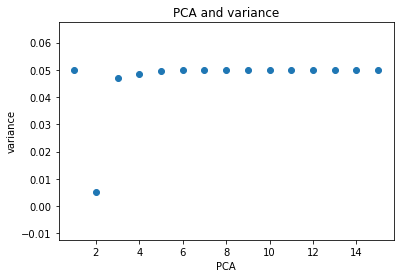

In [0]:
import matplotlib.pyplot as plt
#plotting the graph against PCA and variance
plt.scatter(no_of_comp,var)
plt.title('PCA and variance')
plt.ylabel('variance')
plt.xlabel('PCA')
plt.show()

## Mean Square error 

In [0]:
#finding the mean square error
np.square(X_reconstruct - X).sum(axis=1).mean()

0.06693887014469453

## Plotting eigen values vs indices

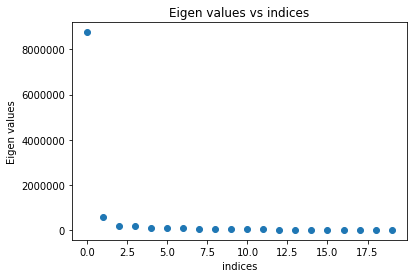

In [0]:
import matplotlib.pyplot as plt
#plotting eigen values against indices
plt.scatter(idx,eigvals)
plt.title('Eigen values vs indices')
plt.ylabel('Eigen values')
plt.xlabel('indices')
plt.show()

In [0]:
# Split the training data and testing data with 80:20 ratio
train_x, test_x, train_y, test_y = train_test_split(X_reconstruct,
train1.iloc[:,-1], train_size=0.8)

In [0]:
train2.head()

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,1.0,1.0,1.0,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,1.0,1.0,1.0,2
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,60.0,60.0,60.0,...,0.494006,0.521783,0.316489,0.421474,0.506190,0.533841,1.0,1.0,1.0,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,60.0,60.0,60.0,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,1.0,1.0,1.0,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,60.0,60.0,60.0,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,1.0,1.0,1.0,1


## Applying Logistic Regression

In [0]:
#Applying Logistic Regression using sklearn library
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200)
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.6197224465819811
Multinomial Logistic regression Test Accuracy :  0.6180686090225563


## Applying Logistic Regression Using Regularization

In [0]:
#Applying Logistic Regression using sklearn library L2 Regularization
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200,penalty='l2')
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.6197224465819811
Multinomial Logistic regression Test Accuracy :  0.6180686090225563


In [0]:
y=mul_lr.predict(train_x)

In [0]:
train_y=train_y.fillna(0)

In [0]:
train_y=train_y.to_numpy()

In [0]:
count=0
for i in range(68095):
    if y[i]!=train_y[i]:
        count=count+1

## Metrics

In [0]:
#loss
(count)/68095

0.38027755341801894

In [0]:
#mean square error
(np.square(y - train_y).sum())/68095

2.2502092664659665

In [0]:
#fscore
from sklearn.metrics import f1_score
f1_score(train_y, y, average='micro')

0.6197224465819811